<a href="https://colab.research.google.com/github/1-Kelvin/moa/blob/peterDataKafkaStream/data-analysis/NewAndBetter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Drive Connection
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/My Drive/Colab Notebooks/big-data/data'/

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1_Y7gB4rfipFsUyp7gshd28gJ_okdV6XR/big-data/data


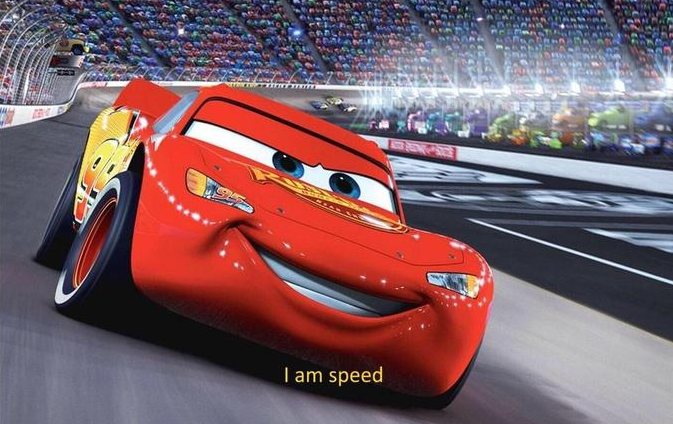

In [ ]:
#@title Load important image
from IPython.display import Image
Image(filename="../speed.png")

# Preparation

In [ ]:
#@title Manage Imports & Extensions
import os.path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 4)})
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path


# pretty prints dataframes
%load_ext google.colab.data_table

In [ ]:
#@title Read Sensor Files
bathroomFiles = ["TA_Bad_1.txt", "TA_Bad_2.txt", "TA_Bad_3.txt", "TA_Bad_4.txt"]
bedroomFiles = ["TA_Schlafen_1.txt", "TA_Schlafen_2.txt", "TA_Schlafen_3.txt" ,"TA_Schlafen_4.txt"]
livingroomFiles = ["TA_Wohnen_1.txt", "TA_Wohnen_2.txt", "TA_Wohnen_3.txt" ,"TA_Wohnen_4.txt"]

addCustomValues = False#@param ["True", "False"] {type:"raw", allow-input: false}
if addCustomValues: 
  bathroomFiles += ["TA_Bad_5.txt"]
  bedroomFiles += ["TA_Schlafen_5.txt"]
  livingroomFiles += ["TA_Wohnen_5.txt"]

def readAndMeregeSensorFiles(paths: list):
  sensor = None
  header_list = ["dateTime"]
  for x in range(len(paths)):
    header_list.append("part_" + str(x))
  for i, file in enumerate(paths):
    header = [header_list[0], header_list[i+1]]
    temp = pd.read_csv("data/" + file, sep="\t", decimal=".", names=header, skiprows=1)
    temp.index = pd.to_datetime(temp["dateTime"])
    temp = temp.drop(columns=["dateTime"])
    if sensor is None:
      sensor = temp
    else:
      sensor = pd.merge_ordered(sensor, temp, left_on = "dateTime", right_on="dateTime", how='outer', fill_method='ffill')
  sensor = sensor.fillna(0)
  sensor = sensor.set_index('dateTime')
  column_list = list(sensor)
  sensor['value'] = sensor[column_list].sum(axis=1) 
  sensor.loc[sensor['value'] > 1, 'value'] = 1
  return sensor

bathroom = readAndMeregeSensorFiles(bathroomFiles)
bedroom = readAndMeregeSensorFiles(bedroomFiles)
livingroom= readAndMeregeSensorFiles(livingroomFiles)
rooms = {"bedroom": bedroom, "livingroom": livingroom, "bathroom": bathroom, }



In [ ]:
#@title General Functions
#@markdown timeDiffInSeconds(df, columnName="duration_in_s")
def timeDiffInSeconds(df: pd.DataFrame, columnName = "duration_in_s"):
  df = df.reset_index()
  df[columnName] = (df['dateTime']-df['dateTime'].shift())
  df[columnName] = df[columnName].shift(-1).dt.total_seconds()
  df = df.set_index('dateTime')
  return df

#@markdown extractDfColumn(df, columnName="value")
def extractDfColumn(df: pd.DataFrame, columnName="value"):
  df = df[columnName]
  return df.to_frame()

def stripDate(date, sizeInMin):
  if sizeInMin / (60 * 24) > 1:
    date = date.replace(hour=0)
  if sizeInMin / 60 > 1:
    date = date.replace(minute=0)
  return date.replace(second=0, microsecond=0)

#@markdown rasterInMinutes(df, sizeInMin=60, indexName="dateTime")
def rasterInMinutes(df: pd.DataFrame, sizeInMin=60, indexName="dateTime", fill_method = "ffill"):
  df = df.reset_index()
  startDate = stripDate(df.iloc[0]["dateTime"], sizeInMin)
  endDate = stripDate(df.iloc[-1]["dateTime"], sizeInMin)
  df = df.set_index(indexName)
  rasteredDf = pd.DataFrame(index=pd.date_range(start=startDate, end=endDate, freq=str(sizeInMin)+'T'))
  rasteredDf.index.name = indexName
  mergedDf = pd.merge_ordered(df,rasteredDf, left_on = "dateTime", right_on="dateTime", how='outer', fill_method=fill_method)
  mergedDf = mergedDf.set_index(indexName)
  return mergedDf

#@markdown removeSameFollowValues(df, column_name="value")
def removeSameFollowValues(df: pd.DataFrame, column_name="value"):
  df["shifted"] = df[column_name].shift(1)
  if isinstance(df.iloc[0][column_name], str): 
    df["shifted"][0]="--" # first one should not be removed
  else:
    df["shifted"][0]=2 # first one should not be removed
  df["change"] = df["shifted"] != df [column_name]
  df = df[df["change"] == True]
  df = df[column_name].to_frame()
  return df

#@markdown filterDfByValue(df, value=1, column_name="value")
def filterDfByValue(df: pd.DataFrame, value = 1, column_name="value"):
  tempIndex = df.index.name
  df = df.reset_index()
  df = df.loc[df[column_name] == value]
  df = df.set_index(tempIndex)
  return df

#@markdown groupByTimeSpan(df, spanInMin=60)
def groupByTimeSpan(df: pd.DataFrame, spanInMin=60, columns=["value"]):
  tempIndex = df.index.name
  df = df.reset_index()
  df = df.groupby([pd.Grouper(key = 'dateTime', freq=str(spanInMin)+'Min')]+ columns).sum()
  df = df.reset_index()
  df = df.set_index(tempIndex)
  return df

def groupByTimeSpanAndGetLatestValue(df: pd.DataFrame, spanInMin, columns=["value"]):
  tempIndex = df.index.name
  df = df.reset_index()
  df = df.groupby([pd.Grouper(key = 'dateTime', freq=str(spanInMin)+'Min')]+ columns)['dateTime'].max().to_frame()
  df = df.rename(columns={"dateTime": "last_"+ tempIndex})
  df = df.reset_index()
  df = df.set_index(tempIndex)
  return df

#@markdown groupByTimeSpanAndAddLastTimeValue(df, spanInMin=60)
def groupByTimeSpanAndAddLastTimeValue(df: pd.DataFrame, spanInMin=60, columns=["value"]):
  tempIndex = df.index.name
  groupedAndSum = groupByTimeSpan(df, spanInMin, columns)
  groupedAndSum = groupedAndSum.reset_index().set_index([tempIndex] + columns)
  groupedAndLastValue = groupByTimeSpanAndGetLatestValue(df, spanInMin, columns)
  groupedAndLastValue = groupedAndLastValue.reset_index().set_index([tempIndex] + columns)
  df = groupedAndSum.join(groupedAndLastValue["last_"+ tempIndex])
  df = df.reset_index().set_index(tempIndex)
  return df

# Analysis

In [ ]:
#@title Calculate room course use variable to continue

def mergeFilterdAndGroupedDf(dfDictionary, timeSpanInMin):
  df = None
  tempIndex = None
  lastSensorChangeName = []
  for key, value in dfDictionary.items():
    tempIndex = value.index.name
    value = rasterInMinutes(value, timeSpanInMin)
    value = timeDiffInSeconds(value) 
    value = groupByTimeSpanAndAddLastTimeValue(value, timeSpanInMin)
    value = filterDfByValue(value)
    value = value[["duration_in_s", "last_"+ tempIndex]]
    value = value.rename(columns={"duration_in_s": key, "last_"+ tempIndex: key + "_changed"})
    lastSensorChangeName += [key + "_changed"] 
    if df is None:
      df = value
    else:  
      df = pd.merge_ordered(df, value, left_on = "dateTime", right_on="dateTime", how='outer', fill_method='None')
  df["lastActiveSensorIn"] = df[lastSensorChangeName].idxmax(axis=1)
  df["lastActiveSensorIn"] = df["lastActiveSensorIn"].str.replace('_changed','')
  df = df[[tempIndex] + list(dfDictionary.keys()) + ["lastActiveSensorIn"]]
  return df.set_index(tempIndex)


def filterRoom(row: pd.Series):
  lastActive = row["lastActiveSensorIn"]
  row = row.drop(labels='lastActiveSensorIn') 
  row = row.astype('float') 
  column = None
  #if hasattr(filterRoom, "columnBefore"):
  #  if row.notnull().sum() > 1 and row.keys()[row.argmax()] == filterRoom.columnBefore:
  #    sorted = row.sort_values(ascending=False)
  #    if sorted[0] > (sorted[1] + 15):
  #      column = sorted.keys()[0]
  #    else:
  #      column = sorted.keys()[1]
  #  else:
  #    column = row.keys()[row.argmax()]
  #else:  
  #  column = row.keys()[row.argmax()]
  row["room"] = lastActive   
  filterRoom.columnBefore = column
  return row

mergedGroupedDf = mergeFilterdAndGroupedDf(rooms, 1)
roomCourse = mergedGroupedDf.apply(filterRoom, axis = 1)
roomCourse = extractDfColumn(roomCourse,"room")
#print(roomCourse)
roomCourse = removeSameFollowValues(roomCourse, column_name="room")
#print(roomCourse)
roomCourse = rasterInMinutes(roomCourse,1)
roomCourse = timeDiffInSeconds(roomCourse)
#print(roomCourse)
roomCourse['duration_in_s'] = roomCourse['duration_in_s'].apply(lambda x: x / 60)
roomCourse = roomCourse.rename(columns={"duration_in_s": "duration_in_min"})
roomCourse
mergedGroupedDf

,bedroom,livingroom,bathroom,lastActiveSensorIn
dateTime,,,,
2018-05-16 22:48:00,4.042,NaN,NaN,bedroom
2018-05-17 00:32:00,7.038,NaN,NaN,bedroom
2018-05-17 00:33:00,15.001,13.021,12.018,bathroom
2018-05-17 00:34:00,NaN,0.992,16.991,livingroom
2018-05-17 00:35:00,14.967,21.987,NaN,bedroom
...,...,...,...,...
2018-05-24 12:33:00,NaN,49.016,NaN,livingroom
2018-05-24 12:34:00,NaN,48.131,NaN,livingroom
2018-05-24 12:35:00,11.050,44.931,NaN,livingroom


In [ ]:
#@title Beautiful Histograms
roomGrouped= groupByTimeSpan(roomCourse, 60*6, ['room'])

print(roomGrouped)

fig = go.Figure()
times = pd.DatetimeIndex(roomGrouped.index)
for date, group in roomGrouped.groupby([times.hour]):
  fig = go.Figure()
  for name, group in group.groupby('room'):
    trace = go.Histogram(x=group.reset_index()['dateTime'], 
                        y=group['duration_in_min'],
                        histfunc='sum',
                        xbins=dict(size=str(60 * 6 * 60000)),
                        autobinx=False)
    trace.name = name
    fig.add_trace(trace)
  fig.update_layout(title="Histogram of total minutes depending on room from " +str(date) + "-" + str(date + 6) + " o'clock",
                    xaxis_title="Date and Rooms",
                    yaxis_title="Duration in minutes",
                    barmode='group')
  fig.show()

                           room  duration_in_min
dateTime                                        
2018-05-16 18:00:00     bedroom             72.0
2018-05-17 00:00:00    bathroom             19.0
2018-05-17 00:00:00     bedroom            309.0
2018-05-17 00:00:00  livingroom             32.0
2018-05-17 06:00:00    bathroom            139.0
...                         ...              ...
2018-05-24 06:00:00     bedroom             14.0
2018-05-24 06:00:00  livingroom            328.0
2018-05-24 12:00:00    bathroom              2.0
2018-05-24 12:00:00     bedroom              1.0
2018-05-24 12:00:00  livingroom             17.0

[94 rows x 2 columns]


In [ ]:
#@title Calculate statistical measurments
roomGrouped = groupByTimeSpan(roomCourse, 60*6, ['room'])
times = pd.DatetimeIndex(roomGrouped.index)
statisticalMetrics = roomGrouped.groupby([times.hour, "room"]).agg(["min", "max","std","mean","median","count"])
statisticalMetrics

duration_in_min                                            
                                min    max         std        mean median count
dateTime room                                                                  
0        bathroom              16.0   43.0    8.568005   22.625000   20.5     8
         bedroom              274.0  316.0   14.262213  299.625000  300.0     8
         livingroom            24.0   56.0    9.996428   37.750000   39.0     8
6        bathroom               5.0  139.0   45.061862   29.500000   13.5     8
         bedroom                4.0   20.0    5.276295   11.875000   12.0     8
         livingroom           211.0  351.0   45.260950  318.625000  333.0     8
12       bathroom               1.0   84.0   28.465518   14.000000    4.0     8
         bedroom                1.0   40.0   13.298765    8.500000    2.0     8
         livingroom            17.0  358.0  116.633737  295.000000  346.5     8
18       bathroom              13.0   23.0    4.000000   18.000000   20.0     7
         bedroom               72.0  300.0   69.328282  234.125000  244.5     8
         livingroom            40.0  105.0   25.959676   84.714286   94.0     7

In [ ]:
#@title Working on histogram intersection
def preprocessHistogram(df:pd.DataFrame):
  if not (df['room'] == 'livingroom').any():
    df=df.append({'room': 'livingroom', 'duration_in_min':0}, ignore_index=True)
  if not (df['room'] == 'bathroom').any():
    df=df.append({'room': 'bathroom', 'duration_in_min':0}, ignore_index=True)
  if not (df['room'] == 'bedroom').any():
    df=df.append({'room': 'bedroom', 'duration_in_min':0}, ignore_index=True)

  #assert that same rooms are intersected 
  sortedDf = df.sort_values(by=['room'])
  return sortedDf['duration_in_min'].to_numpy()

def histogram_intersection(h1, h2):
  h1Np = preprocessHistogram(h1)
  h2Np = preprocessHistogram(h2)

  sumMinH1H2 = np.sum(np.minimum(h1Np,h2Np))
  return sumMinH1H2/np.sum(h1Np)

roomGrouped= groupByTimeSpan(roomCourse, 60*6, ['room'])
times = pd.DatetimeIndex(roomGrouped.index)

for quarters, group in roomGrouped.groupby([times.hour]):
  stateMetricDf = statisticalMetrics.loc[group.index.hour[0]] # 0 == first value (simon)
  # stateMetricDf has multi-index
  baseHist = stateMetricDf.xs('mean', axis=1, level=1).reset_index()
  for day, histogram in group.groupby(pd.DatetimeIndex(group.index).day): 
    print(str(day)+' day\t'+str(quarters)+
          ' quarter\t'+str(histogram_intersection(baseHist, histogram)))


17 day	0 quarter	0.9739583333333334
18 day	0 quarter	0.9493055555555555
19 day	0 quarter	0.9288194444444444
20 day	0 quarter	0.9572916666666667
21 day	0 quarter	0.9899305555555555
22 day	0 quarter	0.9909722222222223
23 day	0 quarter	0.9961805555555555
24 day	0 quarter	0.9545138888888889
17 day	6 quarter	0.6958333333333333
18 day	6 quarter	0.9347222222222222
19 day	6 quarter	0.9100694444444445
20 day	6 quarter	0.9295138888888889
21 day	6 quarter	0.9322916666666666
22 day	6 quarter	0.9774305555555556
23 day	6 quarter	0.9913194444444444
24 day	6 quarter	0.9680555555555556
17 day	12 quarter	0.9480314960629921
18 day	12 quarter	0.9716535433070866
19 day	12 quarter	0.9055118110236221
20 day	12 quarter	0.9700787401574803
21 day	12 quarter	0.9354330708661417
22 day	12 quarter	0.9685039370078741
23 day	12 quarter	0.9385826771653544
24 day	12 quarter	0.06299212598425197
16 day	18 quarter	0.21375178921698562
17 day	18 quarter	0.9147537507289403
18 day	18 quarter	0.9851561257488205
19 day	18 quart

# Playground

In [ ]:
# histogramme - vergleich der zeiträume
# distanz der histogramme ausrechnen - ein tag hernehmen (6 stunden) - vergleich von den bins
# fenster aus normalisierter vergangenheit
# anomalie generieren (ganzer tag im schlafzimmer)